In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from time import sleep
import warnings
warnings.filterwarnings('ignore')
import glob
import datetime
import os

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    mean_squared_error,
    explained_variance_score,
    r2_score,
    roc_auc_score,
    average_precision_score
)
import pickle

## Funcion para registrar el modelo 

Se encarga de guardar:
- El modelo 
- Los parametros del modelo
- Las metricas de score del modelo en crossvalidation
- Los estadisticos de la data que uso

In [2]:
def save_model(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
    user_name,
    tipo_model,
    comentario="",
    params_extras=None,
    metrics_extras=None,
    stats_extras=None,
    split_random_state=None,
    clf_umbral=0.5,
    target_enc_model=None,
    dicc_models_predict_nans=None,
    feature_validation_dict=None,
    save=0,
    dir_results_files="results_files",
    dir_models="models"
):
    """
    tipo_model: 1 = Clasificacion
    tipo_model: 2 = Regression
    """
    if params_extras is None:
        params_extras = dict()
    if metrics_extras is None:
        metrics_extras = dict()
    if stats_extras is None:
        stats_extras = dict()

    today = (
        str(datetime.datetime.now().day)
        + "-"
        + str(datetime.datetime.now().month)
        + "-"
        + str(datetime.datetime.now().year)
        + " "
        + str(datetime.datetime.now().hour)
        + ":"
        + str(datetime.datetime.now().minute)
    )
    today_format = datetime.datetime.strptime(today, "%d-%m-%Y %H:%M")
    def unique_id():
        dt = datetime.datetime.now()
        return (
            f"{dt.year:02d}"
            f"{dt.month:02d}"
            f"{dt.day:02d}"
            + f"{dt.hour:02d}"
            + f"{dt.minute:02d}"
            + f"{dt.second:02d}"
        )
    # Generamos el id del modelo
    model_id = unique_id()
    # Parametros del modelo
    dicc_params = model.get_params()
    dicc_params["Algoritmo"] = str(model).split("(")[0]
    dicc_params["Tipo_modelo"] = tipo_model
    # Parametros de las notas
    dicc_params.update(params_extras)
    # DF
    df_params = pd.DataFrame(dicc_params, index=[user_name + "-" + model_id])
    # Metricas del modelo
    metrics_dct = {}
    if tipo_model == 1:
        # Classification
        metrics_dct["Tipo_metrica"] = "Clasificacion"
        metrics_dct["Tipo_modelo"] = tipo_model
        metrics_dct["Algoritmo"] = str(model).split("(")[0]
        metrics_dct["umbral"] = clf_umbral
        # preds_proba_train = model.predict_proba(X_train)[:, 1]
        # preds_train = preds_proba_train >= clf_umbral
        preds_proba = model.predict_proba(X_test)[:, 1]
        preds = preds_proba >= clf_umbral
        # Training
        # acc_train = accuracy_score(y_train, preds_train)
        # f1_train = f1_score(y_train, preds_train)
        # recall_train = recall_score(y_train, preds_train)
        # precision_train = precision_score(y_train, preds_train)
        # auc_train = roc_auc_score(y_train, preds_proba_train)
        # gini_train = auc_train * 2 - 1
        # Testing
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        recall = recall_score(y_test, preds)
        precision = precision_score(y_test, preds)
        auc_score = roc_auc_score(y_test, preds_proba)
        gini = auc_score * 2 - 1
        prauc = average_precision_score(y_test, preds_proba)
        # gini_diff_testing_train = gini_train - gini
        metrics_dct["AUC"] = auc_score
        metrics_dct["Gini"] = gini
        metrics_dct["PRAUC"] = prauc
        metrics_dct["F1_score"] = f1
        metrics_dct["Accuracy"] = acc
        metrics_dct["Recall"] = recall
        metrics_dct["Precision"] = precision
    elif tipo_model == 2:
        # Regression
        metrics_dct["Tipo_metrica"] = "Regresion"
        metrics_dct["Tipo_modelo"] = tipo_model
        metrics_dct["Algoritmo"] = str(model).split("(")[0]
        metrics_dct["MSE"] = mean_squared_error(y_test, model.predict(X_test))
        metrics_dct["R2"] = r2_score(y_test, model.predict(X_test))
        metrics_dct["Explained_variance"] = explained_variance_score(
            y_test, model.predict(X_test)
        )
    # metrics_extras
    metrics_dct.update(metrics_extras)
    metrics_dct["Fecha"] = today_format
    metrics_dct["Comentario"] = comentario
    # print_metrics
    print()
    print("saved metrics ")
    print("MODEL ID: ", user_name + "-" + model_id)
    for k in metrics_dct.keys():
        print(f"{k}: {metrics_dct[k]}")
    print()
    # Df
    df_metrics = pd.DataFrame(metrics_dct, index=[user_name + "-" + model_id])
    # Stats de la data del modelo
    stats = {}
    stats["Algoritmo"] = str(model).split("()")[0]
    stats["Tipo_modelo"] = tipo_model
    stats["mean_xtrain"] = X_train.describe().iloc[1, :].mean()
    stats["mean_ytrain"] = y_train.mean()
    stats["mean_xtest"] = X_test.describe().iloc[1, :].mean()
    stats["mean_ytest"] = y_test.mean()
    stats["split_random_state"] = split_random_state
    # stats_extras
    stats.update(stats_extras)
    stats["Fecha"] = today_format
    stats["Comentario"] = comentario
    # DF
    df_stats = pd.DataFrame(stats, index=[user_name + "-" + model_id])
    # Features de la data de train
    train = pd.concat([X_train, y_train], axis=1)
    # ^ ES IMPORTANTE que el target este de ultimo!
    df_feats = pd.DataFrame(
        train.columns, columns=[user_name + "-" + model_id]
    ).T
    df_feats.columns = [i for i, c in enumerate(df_feats.columns)]
    # Mean de cada feature
    train = pd.concat([X_train, y_train], axis=1)
    df_feats_train_mean = pd.DataFrame(
        train.mean(), columns=[user_name + "-" + model_id]
    ).T
    # target_enc_model y dicc_models_predict_nans
    if target_enc_model:
        target_enc_model_dir = (
            f"{dir_models}/target_enc_model_"
            + user_name
            + "-"
            + model_id
            + ".pkl"
        )
        with open(target_enc_model_dir, "wb") as file:
            pickle.dump(target_enc_model, file)
    if dicc_models_predict_nans:
        dicc_models_predict_nans_dir = (
            f"{dir_models}/dicc_predict_nans_"
            + user_name
            + "-"
            + model_id
            + ".pkl"
        )
        with open(dicc_models_predict_nans_dir, "wb") as file:
            pickle.dump(dicc_models_predict_nans, file)
    if feature_validation_dict:
        feature_validation_dict_dir = (
            f"{dir_models}/feature_validation_dict_"
            + user_name
            + "-"
            + model_id
            + ".pkl"
        )
        with open(feature_validation_dict_dir, "wb") as file:
            pickle.dump(feature_validation_dict, file)
    if save:
        # Guardamos el modelo en la carpeta de models
        Pkl_Filename = (
            f"{dir_models}/model_" + user_name + "-" + model_id + ".pkl"
        )
        if dir_results_files.startswith("s3"):
            with fs.open(Pkl_Filename, "wb") as file:
                pickle.dump(model, file)
        else:
            with open(Pkl_Filename, "wb") as file:
                pickle.dump(model, file)
        # Guardamos los parametros, metricas y stats
        df_params.to_csv(
            f"{dir_results_files}/params_{user_name}-{model_id}.csv",
            index_label="Model",
        )
        df_metrics.to_csv(
            f"{dir_results_files}/metrics_{user_name}-{model_id}.csv",
            index_label="Model",
        )
        df_stats.to_csv(
            f"{dir_results_files}/stats_{user_name}-{model_id}.csv",
            index_label="Model",
        )
        df_feats.to_csv(
            f"{dir_results_files}/features_train_cols_{user_name}-{model_id}.csv",
            index_label="Model",)

        df_feats_train_mean.to_csv(
            f"{dir_results_files}/features_train_mean_"
            + f"{user_name}-{model_id}.csv",
            index_label="Model",
        )
        print("Modelo, parametros, metricas y stats guardados exitosamente")

## Clase para recoger los modelos guardados con sus parametros, metricas y stats

In [3]:
class ClassModelResults:
    def __init__(self, last_results=0, df_results=None):
        self.last_results = last_results
        self.df_results = {}
        self.df_results["params"] = pd.DataFrame()
        self.df_results["metrics"] = pd.DataFrame()
        self.df_results["stats"] = pd.DataFrame()
        self.df_results["features_train_cols"] = pd.DataFrame()
        self.df_results["features_train_mean"] = pd.DataFrame()
    def get_model_results(self, dir_results_files="results_files",only_last_files=0):
        tipo_file = ["params","metrics","stats","features_train_cols","features_train_mean"]
        df_results = {}
        for t in tipo_file:
            if dir_results_files.startswith("s3"):
                results_files = fs.glob(dir_results_files + "/*")
                results_files = [f.split("/")[-1] for f in results_files]
            else:
                results_files = os.listdir(f"{dir_results_files}/")
                if len(results_files) == 0:
                    os_walk = os.walk(f"{dir_results_files}/", topdown=False)
                    results_files = [[n for n in fls] for _, _, fls in os_walk][
                        0
                    ]
            wanted_files = [f for f in results_files if f.startswith(t)]
            #### ESTO ES PARA SOLO OBTENER LOS ULTIMOS X FILES 
            if only_last_files>0:
                def get_date_from_id(unique_id):
                    return f"{unique_id[:4]}-{unique_id[4:6]}-{unique_id[6:8]} {unique_id[8:10]}:{unique_id[10:12]}:{unique_id[12:14]}"
                id_wanted_files = [f.split('-')[-1].split('.')[0] for f in wanted_files]
                ## Para todos los files antes de este fix
                for i,f in enumerate(id_wanted_files):
                    if len(f)!=14:
                        id_wanted_files[i]="202208"+f
                date_wanted_files = [get_date_from_id(v) for v in id_wanted_files]
                date_wanted_files = [ datetime.datetime.strptime(v,'%Y-%m-%d %H:%M:%S') for v in date_wanted_files]
                date_wanted_files_sort = list(np.argsort(date_wanted_files))
                date_wanted_files_sort.reverse()
                wanted_files = np.array(wanted_files)[date_wanted_files_sort]
                wanted_files = wanted_files[:only_last_files]
            # Para eliminar los files que correspondan a otro tipo
            not_wanted_files = []
            otros_tipo_file = list(set(tipo_file) - set([t]))
            for tf in otros_tipo_file:
                # Por ejemplo si el file comienza con features_train, hay que quitar
                # todos los que digan features_train_mean
                # Sin embargo si el file comienza con features_train_mean no hace
                # falta quitar los que comienzan con features_train porque no estaran en
                # el listado
                not_wanted_files += [
                    f
                    for f in wanted_files
                    if (f.startswith(tf)) & (len(tf) > len(t))
                ]
            wanted_files = list(set(wanted_files) - set(not_wanted_files))
            dfs = []
            for w in wanted_files:
                if int(w.split("-")[-1].split(".")[0]) > self.last_results:
                    try:
                        df = pd.read_csv(f"{dir_results_files}/" + w)
                        dfs.append(df)
                    except BaseException:
                        pass
            if len(dfs) > 0:
                df_concated = pd.concat(dfs, axis=0)
                df_results[t] = df_concated
                self.df_results[t] = pd.concat(
                    [self.df_results[t], df_results[t]], axis=0
                ).drop_duplicates()
        if len(df_results) > 0:
            key = list(df_results.keys())[0]
            self.last_results = int(
                str(df_results[key]["Model"].iloc[-1]).split("-")[-1]
            )
        return self.df_results


    def load_best_model(
        self,
        metrica="F1_score",
        dir_results_files="results_files",
        dir_models="models",
    ):
        """
        metrica:
        - F1_score
        - Accuracy
        - Recall
        - Precision
        - MSE
        - R2
        - Explained_variance
        """
        df_results = self.get_model_results(dir_results_files)
        df_metrics = df_results["metrics"].set_index("Model")
        best_model_idx = df_metrics[metrica].idxmax()
        best_model_name = df_metrics.loc[best_model_idx].name
        # print(best_model_name)
        best_model = load_model(best_model_name, dir_models)
        return best_model

def file_exists_custom(path_to_file):
    try:
        open(path_to_file)
        return True
    except BaseException:
        return False

def load_model(chosen_model_name, dir_models):
    dict_results = {}
    # dicc_predict_nans
    path_to_file = f"{dir_models}/dicc_predict_nans_{chosen_model_name}.pkl"
    if file_exists_custom(path_to_file):
        with open(path_to_file, "rb") as input_file:
            dicc_predict_nans = pickle.load(input_file)
        dict_results["dicc_predict_nans"] = dicc_predict_nans
    # target_enc_model
    path_to_file = f"{dir_models}/target_enc_model_{chosen_model_name}.pkl"
    if file_exists_custom(path_to_file):
        with open(path_to_file, "rb") as input_file:
            target_enc_model = pickle.load(input_file)
        dict_results["target_enc_model"] = target_enc_model
    # chosen_model
    with open(
        f"{dir_models}/model_{chosen_model_name}.pkl", "rb"
    ) as input_file:
        chosen_model = pickle.load(input_file)
    dict_results["chosen_model"] = chosen_model
    return dict_results
def export_model(chosen_model_name, dir_models,dir_export):
    dict_results = {}
    # dicc_predict_nans
    path_to_file = f"{dir_models}/dicc_predict_nans_{chosen_model_name}.pkl"
    filehandler = open(path_to_file, "rb")
    file_obj = pickle.load(filehandler)
    filename = path_to_file.split('/')[-1]
    dir_export_file = dir_export+f'/{filename}'
    filehandler2 = open(dir_export_file, "wb")
    pickle.dump(file_obj,filehandler2)
    # target_enc_model_
    path_to_file = f"{dir_models}/target_enc_model_{chosen_model_name}.pkl"
    filehandler = open(path_to_file, "rb")
    file_obj = pickle.load(filehandler)
    filename = path_to_file.split('/')[-1]
    dir_export_file = dir_export+f'/{filename}'
    filehandler2 = open(dir_export_file, "wb")
    pickle.dump(file_obj,filehandler2)
    # model_
    path_to_file = f"{dir_models}/model_{chosen_model_name}.pkl"
    filehandler = open(path_to_file, "rb")
    file_obj = pickle.load(filehandler)
    filename = path_to_file.split('/')[-1]
    dir_export_file = dir_export+f'/{filename}'
    filehandler2 = open(dir_export_file, "wb")
    pickle.dump(file_obj,filehandler2)

### Creamos multiples modelo de prueba

In [4]:
# df = pd.read_csv("Pokemon.csv")

# ### TRAIN TEST SPLIT
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# ### FEATURE SELECTION
# X_train,X_test=X_train.iloc[:,5:],X_test.iloc[:,5:]



In [5]:
df = pd.read_csv('Titanic_train.csv')

df = pd.get_dummies(df,columns=['Sex'])

target = 'Survived'
X = df[['Pclass','Age','Sex_female','Fare']]
X = X.fillna(0)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:

########## RANDOM FOREST 
n = 10
sleep(1) #Para que sean diferentes id

### MODELING
from sklearn import svm
import xgboost as xgb

#clf = RandomForestClassifier(n_estimators=50+(n*2), max_depth=(n*3), random_state=n)
#clf = svm.SVC(C=n,probability=True)
clf = xgb.XGBClassifier(max_depth=n)
clf.fit(X_train,y_train)

### PREDICTIONS
y_pred = clf.predict(X_test)
#y_probas = clf.predict_proba(X_test)
labels = y.unique()
feature_names = list(X_train.columns)

### Save model
save_model(clf,X_train,X_test,y_train,y_test,"Your_user_name",1,"",
           {},
           {},
           {},
           1,
           save = 1
          )
  

[12:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

saved metrics 
MODEL ID:  Your_user_name-20230312123654
Tipo_metrica: Clasificacion
Tipo_modelo: 1
Algoritmo: XGBClassifier
umbral: 0.5
AUC: 0.8466666666666667
Gini: 0.6933333333333334
PRAUC: 0.8108876087759456
F1_score: 0.7467811158798284
Accuracy: 0.8
Recall: 0.725
Precision: 0.7699115044247787
Fecha: 2023-03-12 12:36:00
Comentario: 

Modelo, parametros, metricas y stats guardados exitosamente


### Initiate object model results

In [7]:
model_results = ClassModelResults()

### Update all models results

In [8]:
dir_results_files = 'results_files'
dir_models = 'models'

In [9]:
df_results = model_results.get_model_results(dir_results_files,only_last_files=6)
len(df_results)

5

In [10]:
df_results.keys()

dict_keys(['params', 'metrics', 'stats', 'features_train_cols', 'features_train_mean'])

### Get metrics, params and stats

In [11]:
df_results["metrics"]

Model   Tipo_metrica  Tipo_modelo      Algoritmo  \
0  Your_user_name-20230226152648  Clasificacion            1  XGBClassifier   
0  Your_user_name-20230312123411  Clasificacion            1  XGBClassifier   
0  Your_user_name-20230226153020  Clasificacion            1  XGBClassifier   
0        Your_user_name-21214718  Clasificacion            1            SVC   
0  Your_user_name-20230226152641  Clasificacion            1  XGBClassifier   
0  Your_user_name-20230312123654  Clasificacion            1  XGBClassifier   

   umbral       AUC      Gini     PRAUC  F1_score  Accuracy    Recall  \
0     0.5  0.846667  0.693333  0.810888  0.746781  0.800000  0.725000   
0     0.5  0.846667  0.693333  0.810888  0.746781  0.800000  0.725000   
0     0.5  0.846667  0.693333  0.810888  0.746781  0.800000  0.725000   
0     0.5  0.763810  0.527619       NaN  0.640441  0.688136  0.645476   
0     0.5  0.873905  0.747810  0.857136  0.737327  0.806780  0.666667   
0     0.5  0.846667  0.693333  0.810888  0.746781  0.800000  0.725000   

   Precision                Fecha  Comentario  
0   0.769912  2023-02-26 15:26:00         NaN  
0   0.769912  2023-03-12 12:34:00         NaN  
0   0.769912  2023-02-26 15:30:00         NaN  
0   0.691590  2023-02-21 21:47:00         NaN  
0   0.824742  2023-02-26 15:26:00         NaN  
0   0.769912  2023-03-12 12:36:00         NaN

In [12]:
df_results["params"]

Model        objective use_label_encoder  \
0  Your_user_name-20230312123654  binary:logistic              True   
0  Your_user_name-20230312123411  binary:logistic               NaN   
0  Your_user_name-20230226153020  binary:logistic             False   
0        Your_user_name-21214718              NaN               NaN   
0  Your_user_name-20230226152648  binary:logistic             False   
0  Your_user_name-20230226152641  binary:logistic             False   

   base_score booster  colsample_bylevel  colsample_bynode  colsample_bytree  \
0         0.5  gbtree                1.0               1.0               1.0   
0         NaN     NaN                NaN               NaN               NaN   
0         0.5  gbtree                1.0               1.0               1.0   
0         NaN     NaN                NaN               NaN               NaN   
0         0.5  gbtree                1.0               1.0               1.0   
0         0.5  gbtree                1.0               1.0               1.0   

  enable_categorical  gamma  ...  class_weight  coef0  \
0              False      0  ...           NaN    NaN   
0              False    NaN  ...           NaN    NaN   
0              False      0  ...           NaN    NaN   
0                NaN  scale  ...           NaN    0.0   
0              False      0  ...           NaN    NaN   
0              False      0  ...           NaN    NaN   

   decision_function_shape  degree  kernel  max_iter  probability  shrinking  \
0                      NaN     NaN     NaN       NaN          NaN        NaN   
0                      NaN     NaN     NaN       NaN          NaN        NaN   
0                      NaN     NaN     NaN       NaN          NaN        NaN   
0                      ovr     3.0     rbf      -1.0         True       True   
0                      NaN     NaN     NaN       NaN          NaN        NaN   
0                      NaN     NaN     NaN       NaN          NaN        NaN   

     tol  verbose  
0    NaN      NaN  
0    NaN      NaN  
0    NaN      NaN  
0  0.001    False  
0    NaN      NaN  
0    NaN      NaN  

[6 rows x 56 columns]

In [13]:
df_results["stats"]

Model  \
0  Your_user_name-20230226153020   
0        Your_user_name-21214718   
0  Your_user_name-20230312123654   
0  Your_user_name-20230312123411   
0  Your_user_name-20230226152641   
0  Your_user_name-20230226152648   

                                           Algoritmo  Tipo_modelo  \
0  XGBClassifier(base_score=0.5, booster='gbtree'...            1   
0                         SVC(C=1, probability=True)            1   
0  XGBClassifier(base_score=0.5, booster='gbtree'...            1   
0  XGBClassifier(base_score=None, booster=None, c...            1   
0  XGBClassifier(base_score=0.5, booster='gbtree'...            1   
0  XGBClassifier(base_score=0.5, booster='gbtree'...            1   

   mean_xtrain  mean_ytrain  mean_xtest  mean_ytest  split_random_state  \
0    14.568977     0.372483    14.86244     0.40678                 1.0   
0    14.568977     0.372483    14.86244     0.40678                 NaN   
0    14.568977     0.372483    14.86244     0.40678                 1.0   
0    14.568977     0.372483    14.86244     0.40678                 1.0   
0    14.568977     0.372483    14.86244     0.40678                 1.0   
0    14.568977     0.372483    14.86244     0.40678                 1.0   

                 Fecha  Comentario  
0  2023-02-26 15:30:00         NaN  
0  2023-02-21 21:47:00         NaN  
0  2023-03-12 12:36:00         NaN  
0  2023-03-12 12:34:00         NaN  
0  2023-02-26 15:26:00         NaN  
0  2023-02-26 15:26:00         NaN

In [14]:

df_results["features_train_cols"]


Model       0    1           2     3         4
0  Your_user_name-20230312123654  Pclass  Age  Sex_female  Fare  Survived
0        Your_user_name-21214718  Pclass  Age  Sex_female  Fare  Survived
0  Your_user_name-20230312123411  Pclass  Age  Sex_female  Fare  Survived
0  Your_user_name-20230226153020  Pclass  Age  Sex_female  Fare  Survived
0  Your_user_name-20230226152641  Pclass  Age  Sex_female  Fare  Survived
0  Your_user_name-20230226152648  Pclass  Age  Sex_female  Fare  Survived

In [15]:

df_results["features_train_mean"]


Model    Pclass        Age  Sex_female       Fare  \
0  Your_user_name-20230226153020  2.337248  23.680235    0.345638  31.912786   
0  Your_user_name-20230226152641  2.337248  23.680235    0.345638  31.912786   
0        Your_user_name-21214718  2.337248  23.680235    0.345638  31.912786   
0  Your_user_name-20230312123654  2.337248  23.680235    0.345638  31.912786   
0  Your_user_name-20230312123411  2.337248  23.680235    0.345638  31.912786   
0  Your_user_name-20230226152648  2.337248  23.680235    0.345638  31.912786   

   Survived  
0  0.372483  
0  0.372483  
0  0.372483  
0  0.372483  
0  0.372483  
0  0.372483

### Last model id

In [16]:
model_results.last_results

20230226152641

### Load model

In [17]:
model_results

In [20]:
load_model(f"Your_user_name-20230312123654",dir_models=dir_models)

{'chosen_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

### Get best model

In [21]:
model_results.load_best_model('AUC')

XGBoostError: [12:38:30] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/common/json.cc:458: Expecting: """, got: "76 ", around character position: 1
    {L\0\0\0\0\0\0\0
    ^~~~~~~~~

## Ploteo de las metricas segun los parametros de cada modelo

XGBClassifier


Model  use_label_encoder_True  booster_gbtree  \
0  Your_user_name-20230312123654                       1               1   
1  Your_user_name-20230312123411                       0               0   
2  Your_user_name-20230226153020                       0               1   
3  Your_user_name-20230226152648                       0               1   
4  Your_user_name-20230226152641                       0               1   

   gamma_0  monotone_constraints_()  use_label_encoder_False  \
0        1                        1                        0   
1        0                        0                        0   
2        1                        1                        1   
3        1                        1                        1   
4        1                        1                        1   

   tree_method_exact  grow_policy_depthwise  predictor_auto  \
0                  1                      0               1   
1                  0                      0               0   
2                  1                      1               1   
3                  1                      1               1   
4                  1                      1               1   

   sampling_method_uniform  F1_score  Accuracy    Recall  Precision  
0                        0  0.746781   0.80000  0.725000   0.769912  
1                        0  0.746781   0.80000  0.725000   0.769912  
2                        1  0.746781   0.80000  0.725000   0.769912  
3                        1  0.746781   0.80000  0.725000   0.769912  
4                        1  0.737327   0.80678  0.666667   0.824742

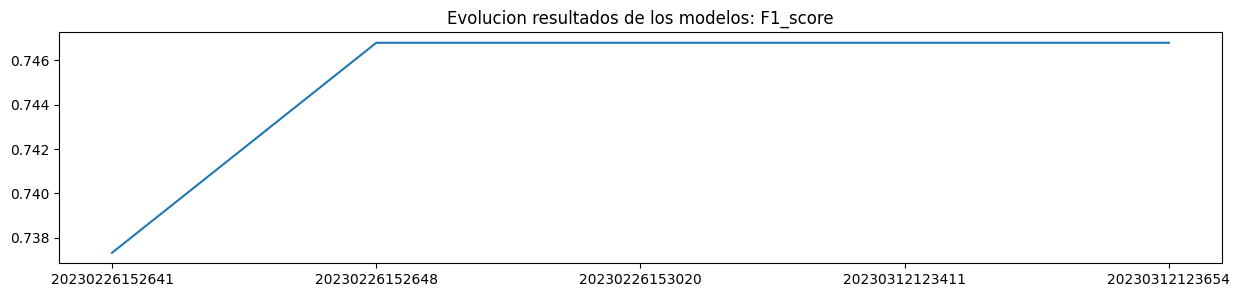

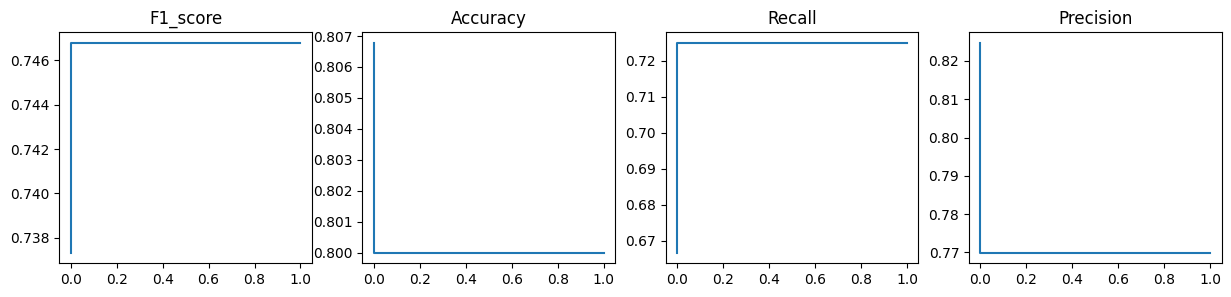

In [22]:
def plot_results_params(df_results,metrica_evo=""):
    
    tipo_modelo = df_results["metrics"].Tipo_modelo.value_counts().idxmax() #Tomaremos el de mayor frecuencia

    if tipo_modelo == 1:
        metricas = ['F1_score','Accuracy','Recall','Precision']
        if metrica_evo=="":
            metrica_evo=metricas[0]
    elif tipo_modelo == 2:
        metricas = ['MSE','R2','Explained_variance']
        if metrica_evo=="":
            metrica_evo=metricas[0]
    
    algs = df_results['params'].Algoritmo.unique()
    
    try:
        df_results["metrics"] = df_results["metrics"].set_index("Model")
        df_results["params"] = df_results["params"].set_index("Model")
    except:
        pass

    
    for a in algs:
        #print(a)

        df_metrics = df_results["metrics"]
        df_metrics = pd.get_dummies(df_metrics[df_metrics.Algoritmo==a])
        df_metrics = df_metrics[list(set(df_metrics.columns)-set(['Algoritmo']))]

        df_params = df_results["params"]
        df_params = pd.get_dummies(df_params[df_params.Algoritmo==a])
        df_params = df_params[list(set(df_params.columns)-set(['Algoritmo']))]

        cols_params = df_params.dropna(axis=1).columns
        #print(cols_params)

        ## Esto es para veo cuales columnas no son estaticas
        cols_params = [c for c in cols_params if df_params[str(c)].diff().sum()>0]
        
        if len(cols_params)>0:
            c = cols_params[0]
            print(a)
            
            df_merged = pd.merge(df_params[cols_params].reset_index(),df_metrics[metricas].reset_index(),how='inner',left_on='Model',right_on='Model')
            display(df_merged)
            
            ## Ploteamos segun fecha del modelo
            plt.figure(figsize=(15, 3),)
            plt.title(f'Evolucion resultados de los modelos: {metrica_evo}')
            df_metrics['date'] = df_metrics.index
            df_metrics['date'] = df_metrics['date'].apply(lambda x: x.split('-')[1])
            df_metrics = df_metrics.sort_values("date")
            plt.plot(df_metrics.date,df_metrics[metrica_evo])
            plt.show()
            
            ## Ploteamos por parametro
            plt.figure(figsize=(15, 3),)
            for i,m in enumerate(metricas,1):
                plt.subplot(1,len(metricas),i)
                plt.plot(df_params[c],df_metrics.loc[df_params.index][m])
                plt.title(m)
            plt.show()

plot_results_params(df_results)